# EDA and Load Estimation of Heating and Cooling Data
Written by Marshall Mykietyshyn

Data hosted at __[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Energy+efficiency)__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from lazypredict.Supervised import LazyRegressor
from my_regression import whitening_transform, adjusted_R2


/home/marshineer/anaconda3/envs/regression/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data Exploration and Pre-processing

In [2]:
# Import the data and check for NaNs
hnc_data = pd.read_csv('data/ENB2012_data.csv')
col_names = ['RelativeCompactness', 'SurfaceArea', 'WallArea', 'RoofArea', 'OverallHeight', 'Orientation', 'GlazingArea',
             'GlazingAreaDistribution', 'HeatingLoad', 'CoolingLoad']
hnc_data.columns = col_names
display(hnc_data.head(n=10))


,RelativeCompactness,SurfaceArea,WallArea,RoofArea,OverallHeight,Orientation,GlazingArea,GlazingAreaDistribution,HeatingLoad,CoolingLoad
0,0.98,514.50,294.00,110.25,7.00,2,0.00,0,15.55,21.33
1,0.98,514.50,294.00,110.25,7.00,3,0.00,0,15.55,21.33
2,0.98,514.50,294.00,110.25,7.00,4,0.00,0,15.55,21.33
3,0.98,514.50,294.00,110.25,7.00,5,0.00,0,15.55,21.33
4,0.90,563.50,318.50,122.50,7.00,2,0.00,0,20.84,28.28
5,0.90,563.50,318.50,122.50,7.00,3,0.00,0,21.46,25.38
6,0.90,563.50,318.50,122.50,7.00,4,0.00,0,20.71,25.16
7,0.90,563.50,318.50,122.50,7.00,5,0.00,0,19.68,29.60
8,0.86,588.00,294.00,147.00,7.00,2,0.00,0,19.50,27.30
9,0.86,588.00,294.00,147.00,7.00,3,0.00,0,19.95,21.97


In [3]:
# Check for NaNs
hnc_data.isna().sum()


RelativeCompactness        0
SurfaceArea                0
WallArea                   0
RoofArea                   0
OverallHeight              0
Orientation                0
GlazingArea                0
GlazingAreaDistribution    0
HeatingLoad                0
CoolingLoad                0
dtype: int64

                     Specs   Score
4            OverallHeight 3111.13
3                 RoofArea 2226.03
1              SurfaceArea  634.18
0      RelativeCompactness  515.76
2                 WallArea  170.92
6              GlazingArea   34.47
7  GlazingAreaDistribution    1.96
5              Orientation    0.16


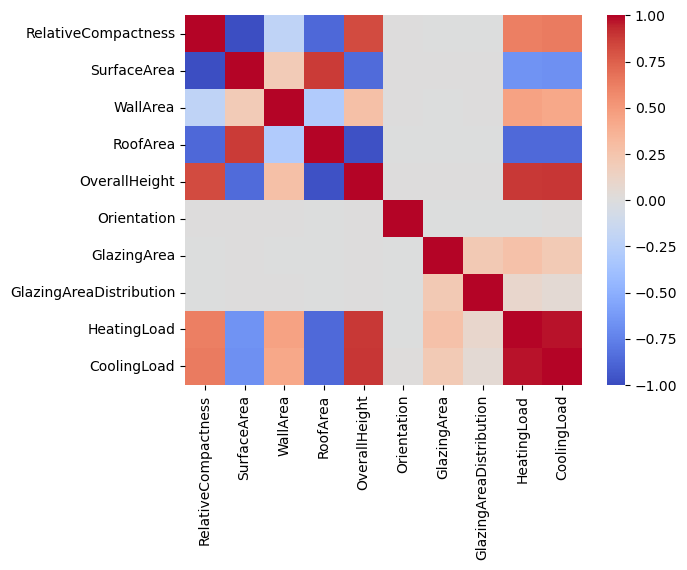

In [4]:
# Perform feature analysis in two ways
X = hnc_data.iloc[:, :-2]
y = hnc_data.iloc[:, -1]
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(10, 'Score'))  #print 10 best features

# Double check with correlation heat map
sns.heatmap(hnc_data.corr(), cmap='coolwarm', vmin=-1, vmax=1);


It appears that Orientation, GlazingArea and GlazingAreaDistribution are not strong predictors of the target values. Therefore, they will be dropped during the analysis. This assumption will be checked later.

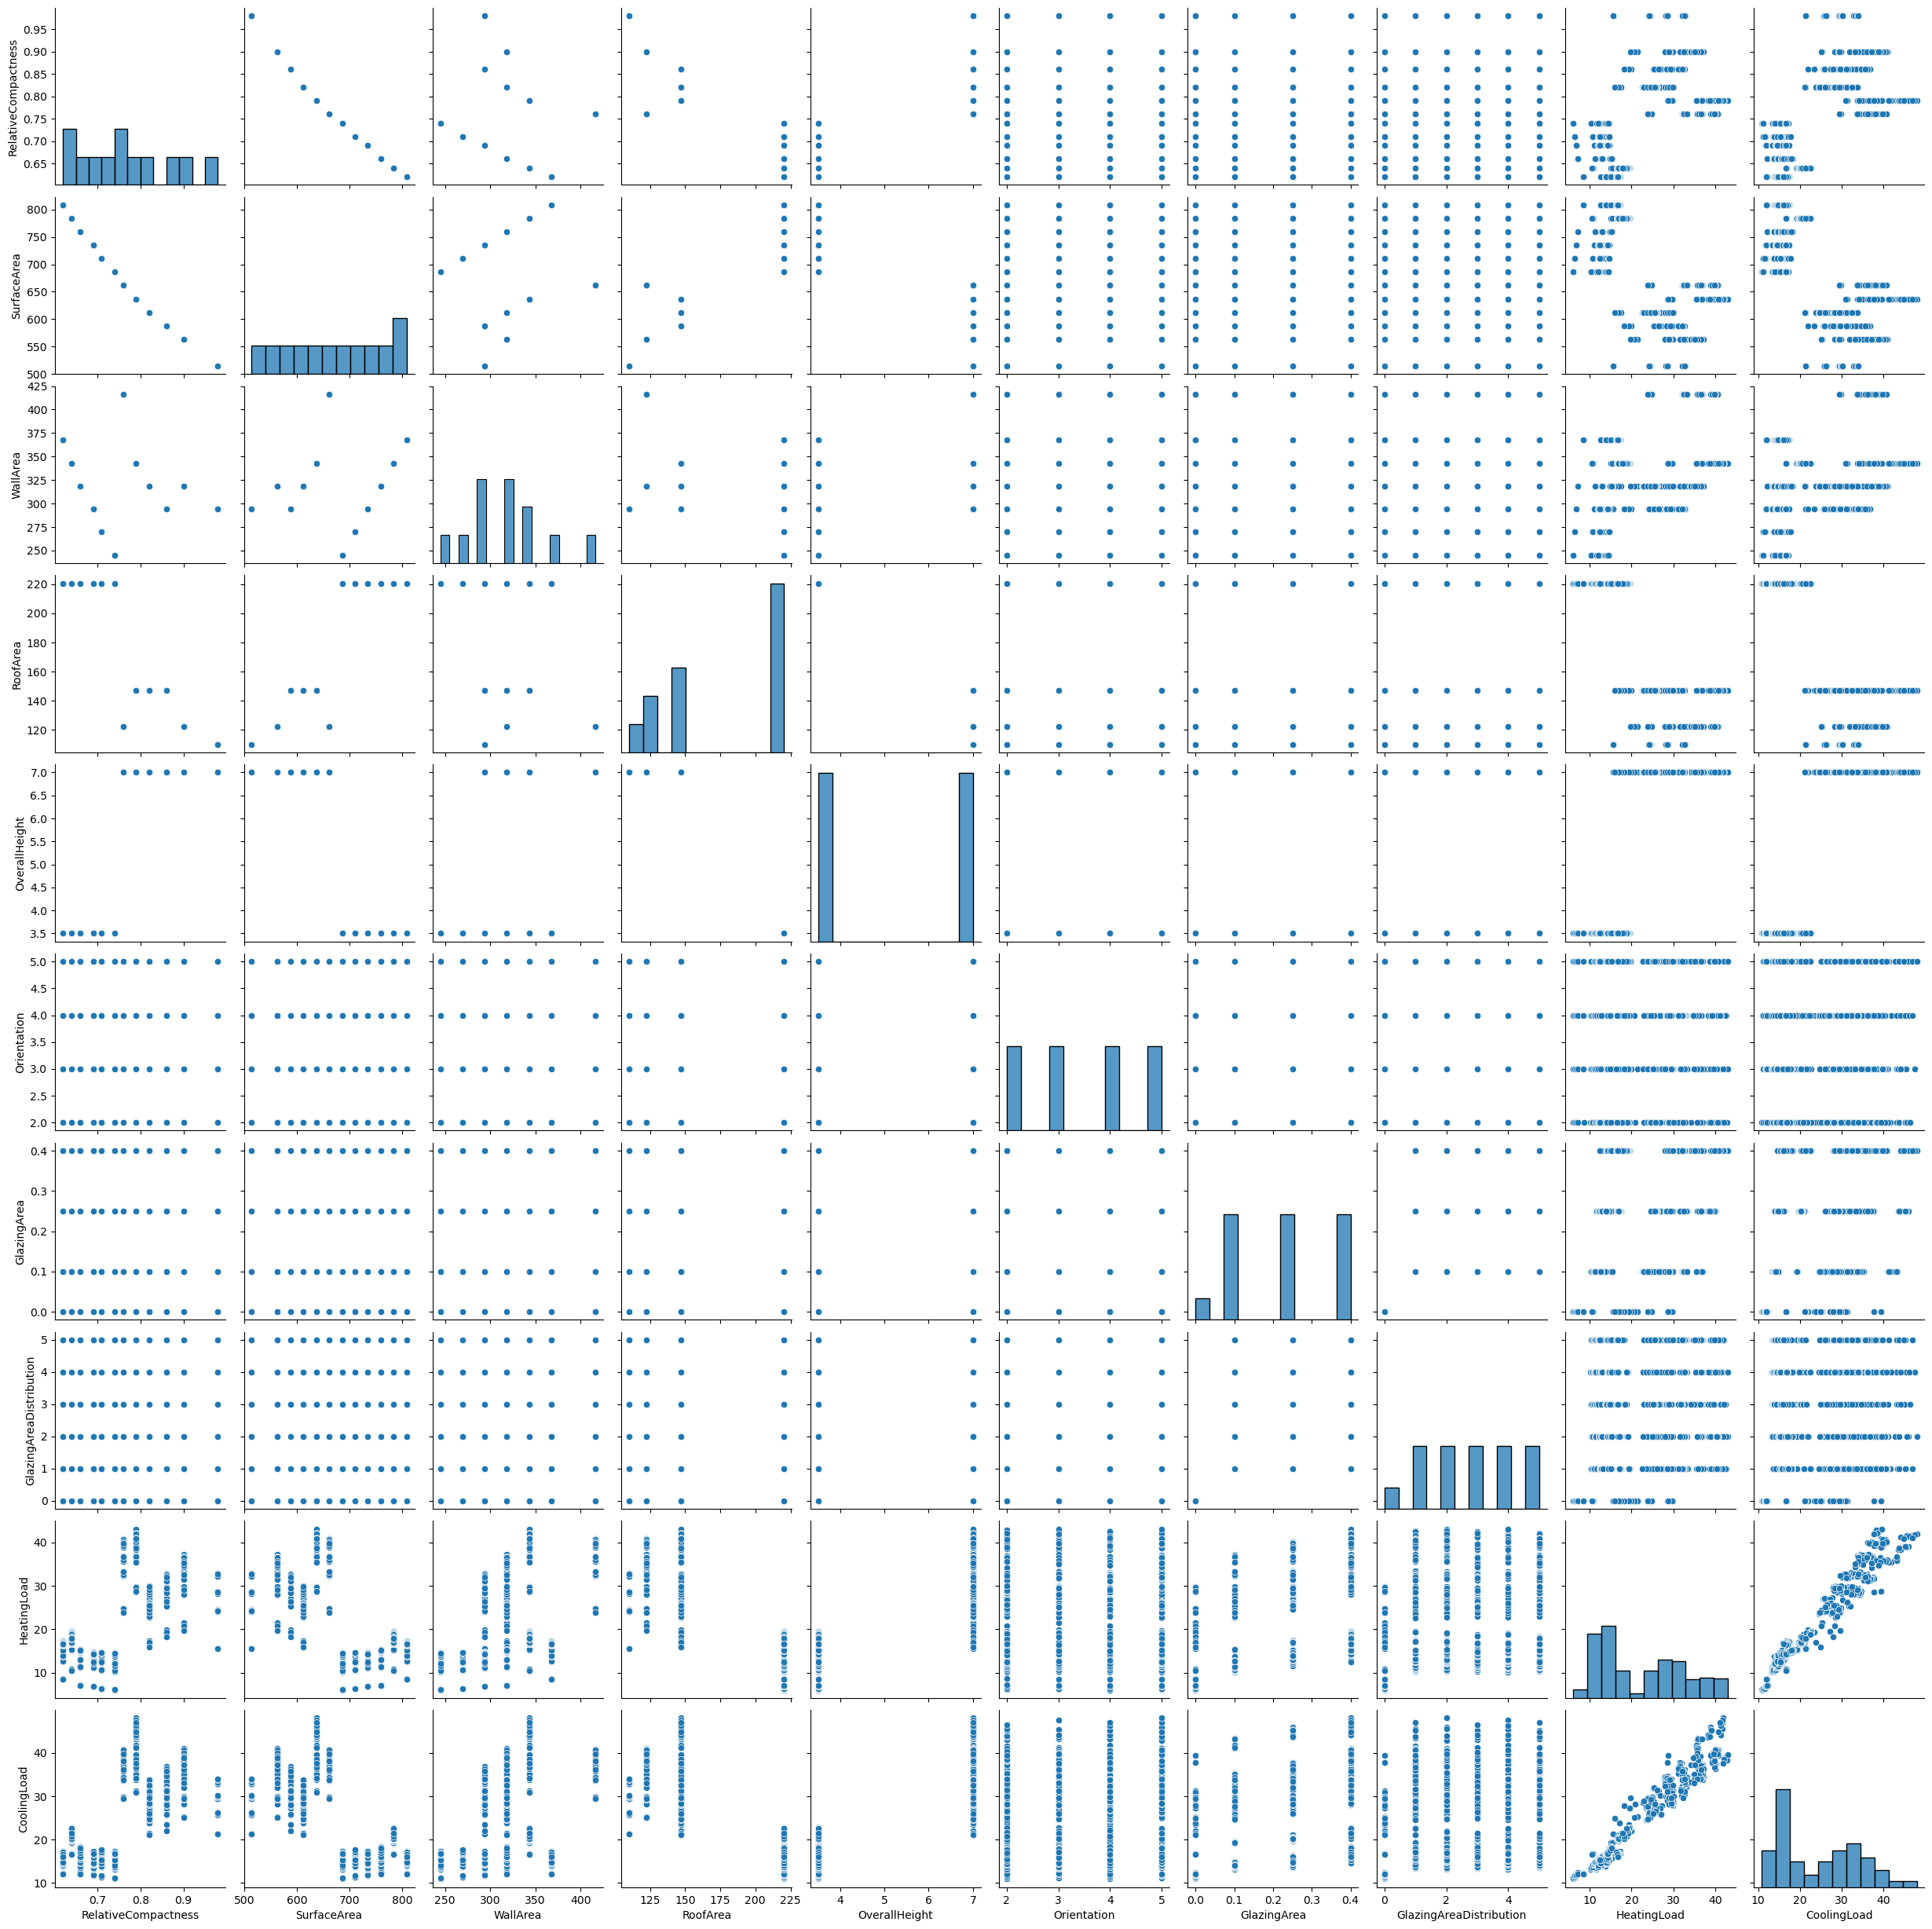

In [5]:
# Look at the distribution of variables and visualize their correlations
sns.pairplot(hnc_data);


In [6]:
# Convert to np.array
hnc_data_select = hnc_data.drop(columns=['Orientation', 'GlazingArea', 'GlazingAreaDistribution', 'WallArea', 'RelativeCompactness'])
hnc_data_nd = hnc_data_select.values


In [7]:
# Split the data into training and test sets
X_nd = hnc_data_nd[:, :-2]
y_nd = hnc_data_nd[:, -2:]
X_train, X_test, y_train, y_test = train_test_split(X_nd,
                                                    y_nd,
                                                    test_size=0.2,
                                                    random_state=66,
                                                    shuffle=True)
N_test, p_test = X_test.shape


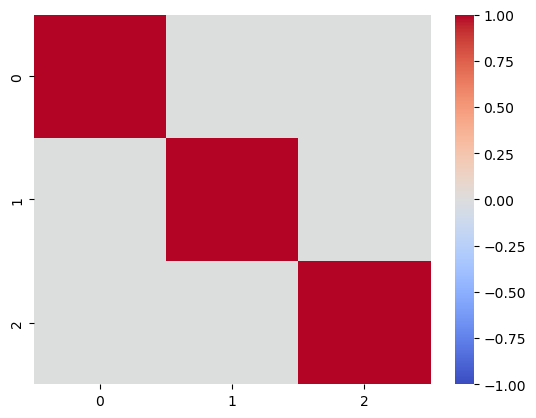

In [8]:
# Whiten the data using the training parameters
# Centering
X_train_center = X_train - X_train.mean(axis=0)
X_test_center = X_test - X_train.mean(axis=0)

# Whitening
W = whitening_transform(X_train_center)
X_white_train = W @ X_train_center.T
X_white_test = W @ X_test_center.T

# Check whitening: covariance matrix should be identity
sns.heatmap(np.cov(X_white_train), cmap='coolwarm', vmin=-1, vmax=1);


Eigenvalue associated with last feature is extremely small. Therefore, there are some numerical instabilities during computation of the eigenvectors that resulted in non-zero covariances after whitening.

# Machine Learning

In [9]:
# Compare several machine learning methods
models = [SVR(kernel="rbf", C=100),
          GradientBoostingRegressor(),
          XGBRegressor(objective='reg:squarederror'),
          LGBMRegressor(),
          ElasticNet()]
model_names = ['SVR', 'Gradient Boost', 'XGBoost', 'LGBM', 'Elastic Net']

perf_cols = ['R^2', 'Adjusted-R^2', 'RMSE']
model_perf = np.zeros((len(models), y_test.shape[1], len(perf_cols)))
for i, model in enumerate(models):
    for j in range(2):
        model.fit(X_train, y_train[:, j])
        y_pred = model.predict(X_test)
        model_perf[i, j, 0] = r2_score(y_test[:, j], y_pred)
        model_perf[i, j, 1] = adjusted_R2(model_perf[i, j, 0], N_test, p_test)
        model_perf[i, j, 2] = mean_squared_error(y_test[:, j], y_pred)
          

In [10]:
# Compare models
heating_perf = pd.DataFrame(model_perf[:, 0, :], columns=perf_cols, index=model_names)
display(heating_perf)
cooling_perf = pd.DataFrame(model_perf[:, 1, :], columns=perf_cols)
# display(cooling_perf)


,R^2,Adjusted-R^2,RMSE
SVR,0.84,0.83,17.61
Gradient Boost,0.90,0.90,10.46
XGBoost,0.90,0.90,10.47
LGBM,0.90,0.90,10.47
Elastic Net,0.81,0.81,20.41


In [11]:
# Compare using lazypredict
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, pred = reg.fit(X_train, X_test, y_train[:, 0], y_test[:, 0])
models


100%|████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 13.75it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.90,0.90,3.23,0.09
GradientBoostingRegressor,0.90,0.90,3.23,0.03
XGBRegressor,0.90,0.90,3.24,0.03
DecisionTreeRegressor,0.90,0.90,3.24,0.00
ExtraTreeRegressor,0.90,0.90,3.24,0.00
ExtraTreesRegressor,0.90,0.90,3.24,0.07
GaussianProcessRegressor,0.90,0.90,3.24,0.02
HistGradientBoostingRegressor,0.90,0.90,3.24,0.35
LGBMRegressor,0.90,0.90,3.24,0.02


## Summary
Lazypredict produced similar baseline results as the manual implementation of five models. In the future, lazypredict seems like a good option for narrowing down the type of model to use. Following this, the model performance should be improved by splitting the data into an additional validation set and running a hyper parameter search. Although it was not relevant in this analysis, unbalanced datasets and missing/NaN values must be solved during pre-processing. Feature selection should continue to be used, although it's value will be assessed in a future project. 
